In [3]:
import ccxt
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime
import time
import sys
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
ohlc = 'ETH-15m-end-2022-04-22.csv' #filename

In [4]:
def Analysis(file_name):
    c = 45/100
    riskratio = 1.5
    print('Analyzing...')
    df = pd.read_csv(file_name)
    df['a'] = abs(df.apply(lambda row: row.High - row.Low, axis=1))
    df['b'] = abs(df.apply(lambda row: row.Close - row.Open, axis=1))
    df['ca'] = df.apply(lambda row: row.a * c, axis=1)
    df['rv'] = np.where(df['b'].values < df['ca'].values,1,0)
    df['x'] = df.apply(lambda row: row.Low + row.ca, axis=1)
    df['y'] = df.apply(lambda row: row.High - row.ca, axis=1)
    df['sl'] = np.where((df['High'].values>df['y'].values) & (df['Close'].values<df['y'].values) & (df['Open'].values<df['y'].values),1,0)
    df['ss'] = np.where((df['Low'].values<df['x'].values) & (df['Close'].values>df['x'].values) & (df['Open'].values>df['x'].values),1,0)
    df['longlimit'] = np.where((df['sl'] > 0), df['High'].values,np.NaN)
    df['longlimit'] = df['longlimit'].ffill()
    df['longlimit'] = np.array(df['longlimit']).tolist()
    df['shortlimit'] = np.where((df['ss'] > 0), df['Low'].values,np.NaN)
    df['shortlimit'] = df['shortlimit'].ffill()
    df['shortlimit'] = np.array(df['shortlimit']).tolist()
    df['hc'] = df.High - df.Low
    df['hcs'] = abs(df.High-df.Close.shift(1))
    df['lcs'] = abs(df.Low-df.Close.shift(1))
    df['rt'] = df[['hc','hcs','lcs']].max(axis=1)
    df['slow'] = ta.sma(df['Close'],5)
    df['fast'] = ta.ema(df['Close'],18)
    df['trend 1'] = ta.sma(df['Close'],50)
    df['trend 2'] = ta.sma(df['Close'],89)
    df['trend 3'] = ta.ema(df['Close'],144)
    df['mid'] = ta.ema(df['Close'],35)
    df['lower'] = ta.ema(df['Close'],35) + 0.5*(ta.rma(df['rt'],35))
    df['longOn'] = np.where((df.slow.values>df.fast.values)&(df['trend 1'].values<df.fast.values)&(df['trend 2'].values<df.fast.values)&(df['trend 3'].values<df.fast.values)&(df['mid'].values<df.fast.values)&(df['lower'].values<df.fast.values),'y','n')
    df['shortOn'] = np.where((df.slow.values<df.fast.values)&(df['trend 1'].values>df.fast.values)&(df['trend 2'].values>df.fast.values)&(df['trend 3'].values>df.fast.values)&(df['mid'].values>df.fast.values)&(df['lower'].values>df.fast.values),'y','n')
    df['longstop'] = np.where((df['slow'].values>df['Low'].values),df['fast'].values,df['slow'].values)
    df['shortstop'] = np.where((df['slow'].values<df['High'].values),df['fast'].values,df['slow'].values)
    df['longtarget'] = df.apply(lambda row: abs((row.longstop / row.longlimit) - 1)*riskratio, axis=1)
    df['longtarget'] = df.apply(lambda row: (row.longlimit * (row.longtarget + 1)), axis=1)
    df['shorttarget'] = df.apply(lambda row: abs((row.shortstop / row.shortlimit) - 1)*riskratio, axis=1)
    df['shorttarget'] = df.apply(lambda row: (row.shortlimit * (1 - row.shorttarget)), axis=1)
    pd.set_option('display.max_rows', df.shape[0]+1)
    pd.set_option('display.max_columns',df.shape[0]+1)
    return df

In [5]:
def getSignals(df):
    print('Getting signals...')
    Longs = []
    Shorts = []
    ExitLongs = []
    ExitShorts = []
    maxLen = 50
    for i in range(len(df)):
        if 'y' in df['longOn'].iloc[i] and 'n' in df['longOn'].iloc[i-1]:
            if df['High'].iloc[i]>df['longlimit'].iloc[i]:
                Longs.append(df.iloc[i].Timestamp)
                for j in range(1,maxLen):
                    if (df['High'].iloc[i+j]>df['longtarget'].iloc[i+j]) or (df['Low'].iloc[i+j]<df['longstop'].iloc[i+j]):
                        ExitLongs.append(df.iloc[i+j].Timestamp)
                        break
    for i in range(len(df)):
        if 'y' in df['shortOn'].iloc[i] and 'n' in df['shortOn'].iloc[i-1]:
            if df['Low'].iloc[i]>df['shortlimit'].iloc[i]:
                Shorts.append(df.iloc[i].Timestamp)
                for j in range(1,maxLen):
                    if (df['High'].iloc[i+j]>df['shortstop'].iloc[i+j]) or (df['Low'].iloc[i+j]<df['shortlimit'].iloc[i+j]):
                        ExitShorts.append(df.iloc[i+j].Timestamp)
                        break
    return Longs,Shorts,ExitLongs,ExitShorts

In [8]:
def Plot(df, Longs, Shorts):
    plt.figure(figsize=(12,5))
    plt.plot(df['Close'], alpha=0.7)

Analyzing...
Getting signals...


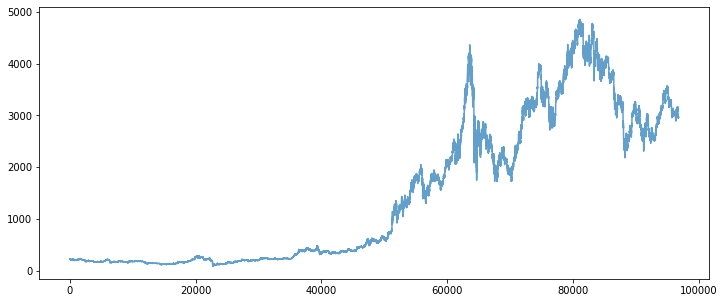

In [9]:
df = Analysis(ohlc)
Longs,Shorts,ExitLongs,ExitShorts = getSignals(df)
Plot(df,Longs,Shorts)